In [1]:
#@title Install package
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1

In [2]:
#@title Import library
import gym
import numpy as np
import random
import time
from IPython import display as ipythondisplay
import matplotlib.pyplot as plt

In [3]:
#@title Define hyperparameters
gamma = 0.99
learning_rate = 0.1
max_epsilon = 1.0
min_epsilon = 0.01
epsilon_decay_rate = 0.005

num_episodes = 20000
num_steps_per_episode = 100

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
#@title Q-Learning
def q_learning(env, num_episodes, num_steps_per_episode, learning_rate, gamma, max_epsilon, min_epsilon, epsilon_decay_rate):
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    rewards_all = []
    for episode in range(num_episodes):
        state = env.reset()

        reward_episode = 0.0
        done = False
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-epsilon_decay_rate*episode)
        for step in range(num_steps_per_episode):
            exploration = random.uniform(0,1)
            if exploration < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state, :])

            next_state, reward, done, info = env.step(action)
            q_table[state, action] = q_table[state, action] * (1 - learning_rate) + learning_rate * (reward + gamma * np.max(q_table[next_state,:]))

            reward_episode += reward
            state = next_state

            if done:
                break
        rewards_all.append(reward_episode)
    print(f'Episode {episode} finished')
    return q_table, rewards_all

In [5]:
#@title SARSA
def sarsa(env, num_episodes, num_steps_per_episode, learning_rate, gamma, max_epsilon, min_epsilon, epsilon_decay_rate):
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    rewards_all = []

    for episode in range(num_episodes):
        state = env.reset()
        reward_episode = 0.0
        done = False
        # Sample action a from policy Pi(b) => (s,a,r,s')
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-epsilon_decay_rate*episode)
        exploration = random.uniform(0,1)
        if exploration < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state, :])

        for step in range(num_steps_per_episode):
            next_state, reward,done,info = env.step(action)
            # sample action a' from policy Pi(b) => (s',a',r'',s'')
            exploration = random.uniform(0,1)
            if exploration < epsilon:
                action_prime = env.action_space.sample()
            else:
                action_prime = np.argmax(q_table[next_state, :])
            # Calculate sample
            sample = reward + gamma*q_table[next_state,action_prime]
            q_table[state, action] = q_table[state,action] + learning_rate*(sample - q_table[state,action])

            reward_episode += reward
            state = next_state
            action = action_prime

            if done:
                break
        rewards_all.append(reward_episode)
    print(f'Episode {episode} finished')
    return q_table, rewards_all

# Games

In [6]:
#@title Graph
window = 100
def calculateAverage_y(rewards_all):
  average_y = []
  for ind in range(len(rewards_all) - window + 1):
      average_y.append(np.mean(rewards_all[ind:ind+window]))
  for ind in range(window - 1):
      average_y.insert(0, np.nan)
  return average_y

def graph(average_y,rewards_all,average_y1,rewards_all1):
  plt.figure(figsize=(10, 5))
  plt.plot(np.arange(len(rewards_all)), average_y, color='magenta', label='Q-Learning')
  plt.plot(np.arange(len(rewards_all1)), average_y1, color='green', label='SARSA')
  plt.yticks([0, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
  plt.grid()
  plt.xlabel('Episodes')
  plt.ylabel(f'Average over {window} episodes')
  plt.legend()
  plt.show()

In [7]:
#@title Play game
from pyvirtualdisplay import Display
import warnings
display = Display(visible=0, size=(720, 480))
display.start()
warnings.filterwarnings("ignore", category=DeprecationWarning)

def play(env, q_table, render=False):
    state = env.reset()
    total_reward = 0
    steps = 0
    done = False

    if render:
        plt.axis('off')

    while not done:
        action = np.argmax(q_table[state, :])
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        steps += 1
        if render:
            print(f"{state} --> {next_state}")
            time.sleep(0.5)
            screen = env.render(mode='rgb_array')
            plt.imshow(screen)
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())
            time.sleep(0.5)

        state = next_state

    return (total_reward, steps)

def play_multiple_times(env, q_table, max_episodes):
    success = 0
    list_of_steps = []
    for i in range(max_episodes):
        total_reward, steps = play(env, q_table)

        if total_reward > 0:
            success += 1
            list_of_steps.append(steps)

    print(f'Number of successes: {success}/{max_episodes}')
    print(f'Average number of steps: {np.mean(list_of_steps)}')

In [8]:
#@title FronzenLakee-v1 with Q-Learning
env = gym.make('FrozenLake-v1')
q_table_qlearing, rewards_all_qlearning = q_learning(env, num_episodes, num_steps_per_episode, learning_rate, gamma, max_epsilon, min_epsilon, epsilon_decay_rate)
print("q_table:\n",q_table_qlearing)
print("rewards:\n",sum(rewards_all_qlearning))
play_multiple_times(env, q_table_qlearing, 1000)

Episode 19999 finished
q_table:
 [[4.91121630e-01 4.86717151e-01 4.83162008e-01 4.80283524e-01]
 [3.04969254e-01 2.41831438e-01 1.94208451e-01 3.74258363e-01]
 [3.14926209e-01 2.67239711e-01 2.68503201e-01 2.68263902e-01]
 [2.34086271e-01 3.81680796e-02 7.61555723e-04 3.82072765e-02]
 [5.09363665e-01 4.63786566e-01 2.85933057e-01 4.89805391e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.81364298e-01 1.54231044e-01 2.58748356e-01 9.56189501e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.55338070e-01 3.96841139e-01 4.02257404e-01 5.28563871e-01]
 [4.78402106e-01 5.50624063e-01 5.10943492e-01 4.22074165e-01]
 [5.10946567e-01 3.56424976e-01 3.20356159e-01 2.58513659e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.36399233e-01 6.27388470e-01 6.87478731e-01 5.16658850e-01]
 [7.10792056e-01 8.93439198e-01 7.61578671e-01 7.54259961e-01]
 [0.00000000e+00 0.000

In [9]:
#@title FronzenLakee-v1 with SARSA
env = gym.make('FrozenLake-v1')
q_table_sarsa, rewards_all_sarsa = sarsa(env, num_episodes, num_steps_per_episode, learning_rate, gamma, max_epsilon, min_epsilon, epsilon_decay_rate)
print("q_table:\n",q_table_sarsa)
print("rewards:\n",sum(rewards_all_sarsa))
play_multiple_times(env, q_table_sarsa, 1000)

Episode 19999 finished
q_table:
 [[0.47387852 0.42943415 0.39983866 0.42783468]
 [0.0815812  0.30551774 0.01017677 0.00414057]
 [0.26752384 0.19760595 0.1982896  0.16620279]
 [0.10996359 0.13857121 0.05426106 0.22123183]
 [0.50750007 0.27777984 0.38896939 0.35083002]
 [0.         0.         0.         0.        ]
 [0.24782127 0.12857225 0.12606251 0.05316393]
 [0.         0.         0.         0.        ]
 [0.4617074  0.33836736 0.37121449 0.55001786]
 [0.4426171  0.59271884 0.454982   0.32913053]
 [0.6094666  0.3191893  0.38841798 0.2309741 ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.43865367 0.48859676 0.72932076 0.52132989]
 [0.67619332 0.83794377 0.75208791 0.70036448]
 [0.         0.         0.         0.        ]]
rewards:
 11540.0
Number of successes: 700/1000
Average number of steps: 37.05428571428571


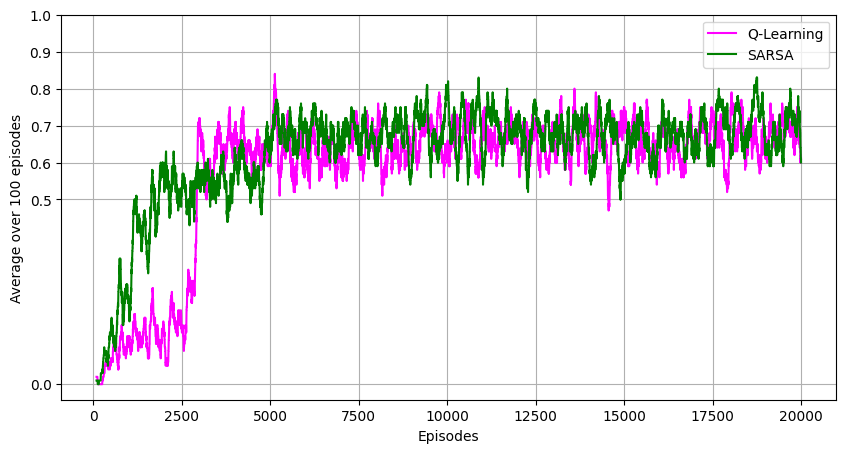

In [10]:
graph(calculateAverage_y(rewards_all_sarsa),rewards_all_sarsa,calculateAverage_y(rewards_all_qlearning),rewards_all_qlearning)

Nhận xét:

*   Hai thuật toán đảm bảo hội tụ về một phương án tối ưu sau 20000 episodes.
*   Ở 2500 episodes đầu, SARSA đạt được average reward cao hơn, nhưng sau đó cả 2 thuật toán đều hội tụ về một mức average reward xấp xỉ nhau.



In [11]:
#@title FrozenLake8x8-v1 with Q-Learning
env = gym.make('FrozenLake8x8-v1')
q_table_qlearing, rewards_all_qlearning = q_learning(env, num_episodes, num_steps_per_episode, learning_rate, gamma, max_epsilon, min_epsilon, epsilon_decay_rate)
print("q_table:\n",q_table_qlearing)
print("rewards:\n",sum(rewards_all_qlearning))
play_multiple_times(env, q_table_qlearing, 1000)

Episode 19999 finished
q_table:
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
reward

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [12]:
#@title FrozenLake8x8-v1 with SARSA
env = gym.make('FrozenLake8x8-v1')
q_table_sarsa, rewards_all_sarsa = sarsa(env, num_episodes, num_steps_per_episode, learning_rate, gamma, max_epsilon, min_epsilon, epsilon_decay_rate)
print("q_table:\n",q_table_sarsa)
print("rewards:\n",sum(rewards_all_sarsa))
play_multiple_times(env, q_table_sarsa, 1000)

Episode 19999 finished
q_table:
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
reward

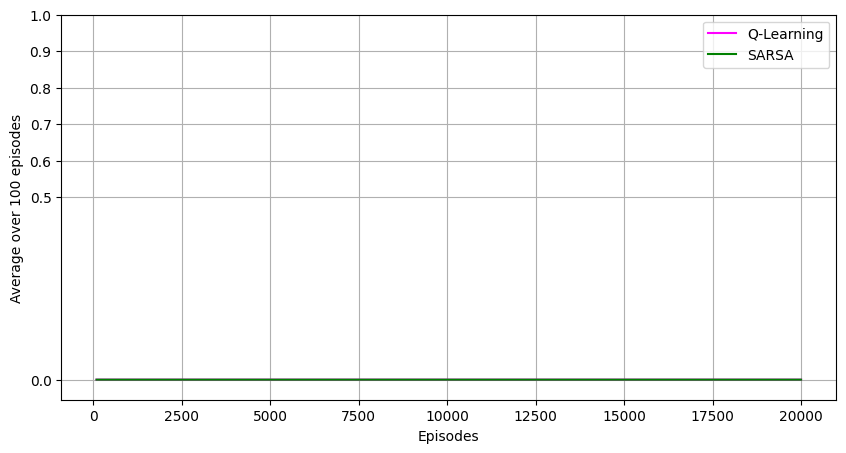

In [13]:
graph(calculateAverage_y(rewards_all_sarsa),rewards_all_sarsa,calculateAverage_y(rewards_all_qlearning),rewards_all_qlearning)

Nhận xét:

*   Game FrozenLake8x8-v1 khá khó, cả hai thuật toán đều không đạt được phương tối ưu.
*   Đều thua sau 1000 ván chơi thử.

In [14]:
#@title Taxi-v3 with Q-Learning
env = gym.make('Taxi-v3')
q_table_qlearing, rewards_all_qlearning = q_learning(env, num_episodes, num_steps_per_episode, learning_rate, gamma, max_epsilon, min_epsilon, epsilon_decay_rate)
print("q_table:\n",q_table_qlearing)
print("rewards:\n",sum(rewards_all_qlearning))
play_multiple_times(env, q_table_qlearing, 1000)

Episode 19999 finished
q_table:
 [[ 0.          0.          0.          0.          0.          0.        ]
 [-3.01316965 -2.90896363  0.61262187 -1.71756981  9.6220697  -8.02638565]
 [ 3.74788201  2.15842148  0.18366633  2.48805555 14.11880599 -0.53209654]
 ...
 [-1.28816991 -1.12594197 -1.27140149 -1.2350528  -4.27663999 -1.999     ]
 [-2.74430533 -2.0613739  -2.73391735 -2.67261494 -4.40989307 -6.71548643]
 [-0.1999      5.88408129 -0.1        -0.1        -1.         -1.        ]]
rewards:
 2730.0
Number of successes: 1000/1000
Average number of steps: 13.191


In [15]:
#@title Taxi-v3 with SARSA
env = gym.make('Taxi-v3')
q_table_sarsa, rewards_all_sarsa = sarsa(env, num_episodes, num_steps_per_episode, learning_rate, gamma, max_epsilon, min_epsilon, epsilon_decay_rate)
print("q_table:\n",q_table_sarsa)
print("rewards:\n",sum(rewards_all_sarsa))
play_multiple_times(env, q_table_sarsa, 1000)

Episode 19999 finished
q_table:
 [[ 0.          0.          0.          0.          0.          0.        ]
 [-1.80654307 -1.27394991 -2.0050208  -1.24040444  7.86724175 -6.50760535]
 [-0.24742824  0.12654545 -2.01993145 -2.77122714 13.92054764 -1.04094913]
 ...
 [-1.77330903 -1.68039407 -1.70793846  2.06845252 -2.76023672 -5.04378666]
 [-3.17824743 -2.66180794 -3.30033398 -3.24775478 -5.73798147 -6.97289996]
 [-0.44750637 -0.19       -0.29709811 13.44987348 -3.50861369 -1.00013713]]
rewards:
 4347.0
Number of successes: 1000/1000
Average number of steps: 13.031


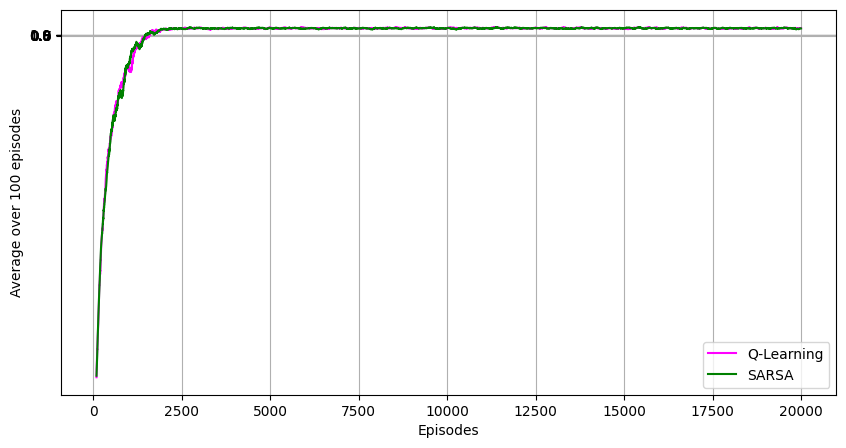

In [16]:
graph(calculateAverage_y(rewards_all_sarsa),rewards_all_sarsa,calculateAverage_y(rewards_all_qlearning),rewards_all_qlearning)

Nhận xét:

*   Cả hai thuật toán đều đạt được phương án tối ưu.
*   Nhìn vào đồ thị, 2 đường biểu thị average reward của 2 thuật toán khá giống nhau.